# Why is Dimensionality Reduction Important

Principal reasons to consider dimensionality reduction techniques in your workflow:

* visualization
* remove multicolinearity
* remove redundant features
* deal with the curse of dimensionality
* identify structure for supervised learning
* high-dimensional data

# Setup

In [1]:
!pip install joblib

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import joblib
import os
import time

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Dimension Reduction

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal",
               "Shirt", "Sneaker", "Bag", "Ankle boot"]

Ankle boot


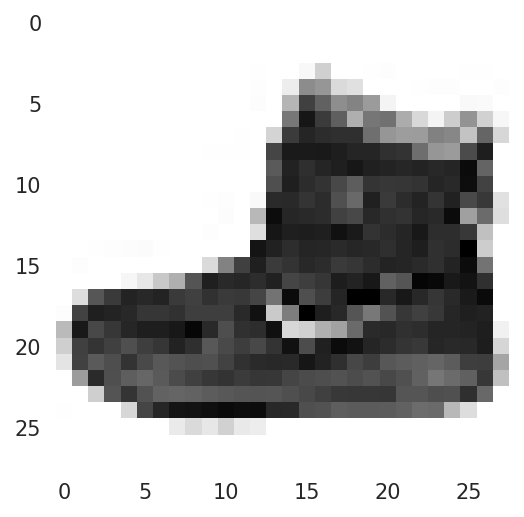

In [4]:
## look at sample image
fig = plt.figure(figsize=(4, 4), dpi=150, facecolor="white")
ax = fig.add_subplot(111)
img_ind = 0

ax.imshow(train_images[img_ind])
ax.grid(False)
print(class_names[train_labels[img_ind]])

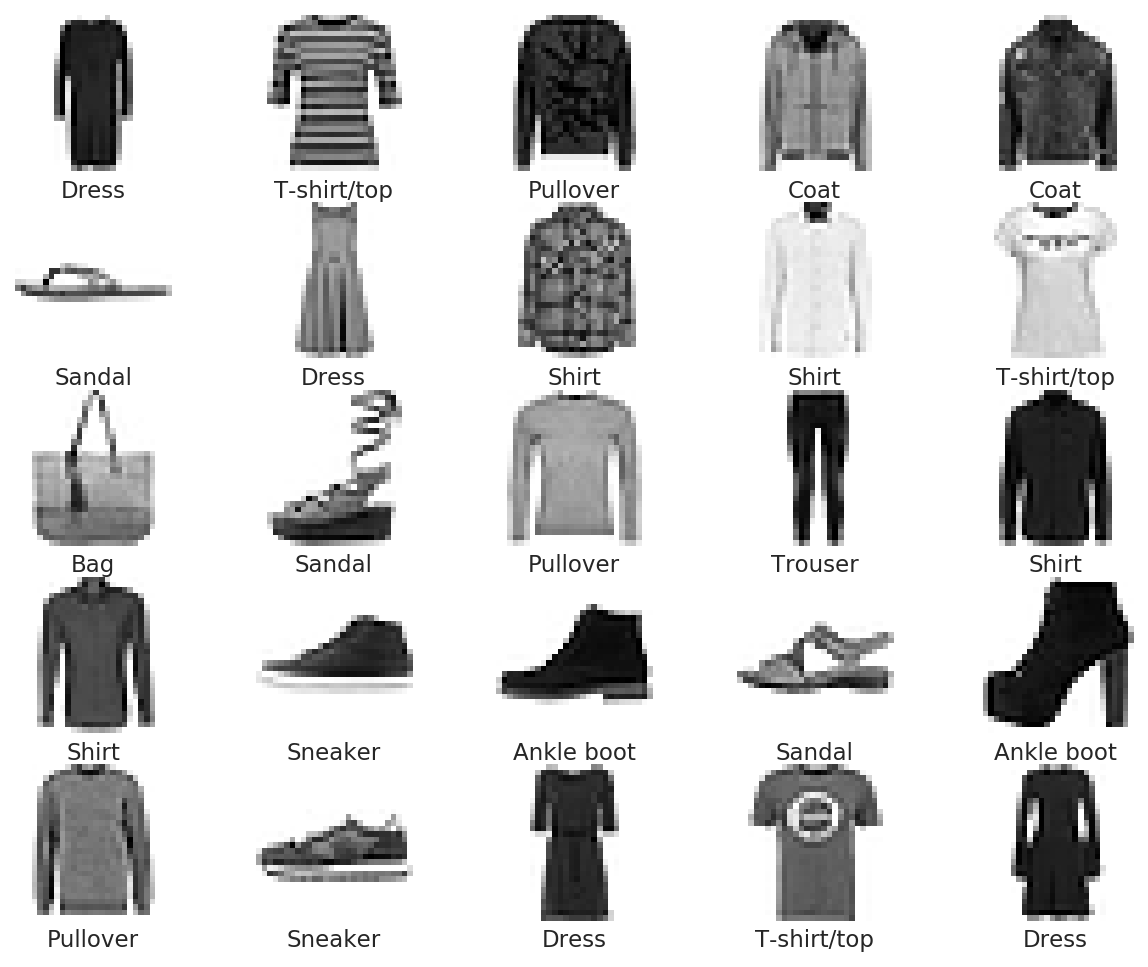

In [5]:
fig = plt.figure(figsize=(10, 8), dpi=150, facecolor="white")
offset = 25
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.imshow(train_images[i+offset], cmap=plt.cm.binary)
    ax.set_xlabel(class_names[train_labels[i+offset]])

In [6]:
## scale the values to a range of 0 to 1 of both datasets
train_images = train_images / 255.0
test_images = test_images / 255.0

## subset the data
subset = np.array([0,1,2,3,4])
train_subset = np.in1d(train_labels, subset)
train_labels = train_labels[train_subset]
train_images = train_images[train_subset]

test_subset = np.in1d(test_labels, subset)
test_labels = test_labels[test_subset]
test_images = test_images[test_subset]

## flatten the images to be 784 pixel vectors
X_train = np.array([i.flatten() for i in train_images])
X_test = np.array([i.flatten() for i in test_images])
y_train = train_labels
y_test = test_labels

## print basic information about the data
print("X_train: {}".format(X_train.shape))
class_info = list(sorted(Counter(y_train).items()))
print("num classes: {}, classes:{}".format(len(class_info), [i[0] for i in class_info]))
print("class samples: {}".format([i[1] for i in class_info]))
print("class balance: {}".format([round(i[1]/X_train.shape[0], 2) for i in class_info]))

X_train: (30000, 784)
num classes: 5, classes:[0, 1, 2, 3, 4]
class samples: [6000, 6000, 6000, 6000, 6000]
class balance: [0.2, 0.2, 0.2, 0.2, 0.2]


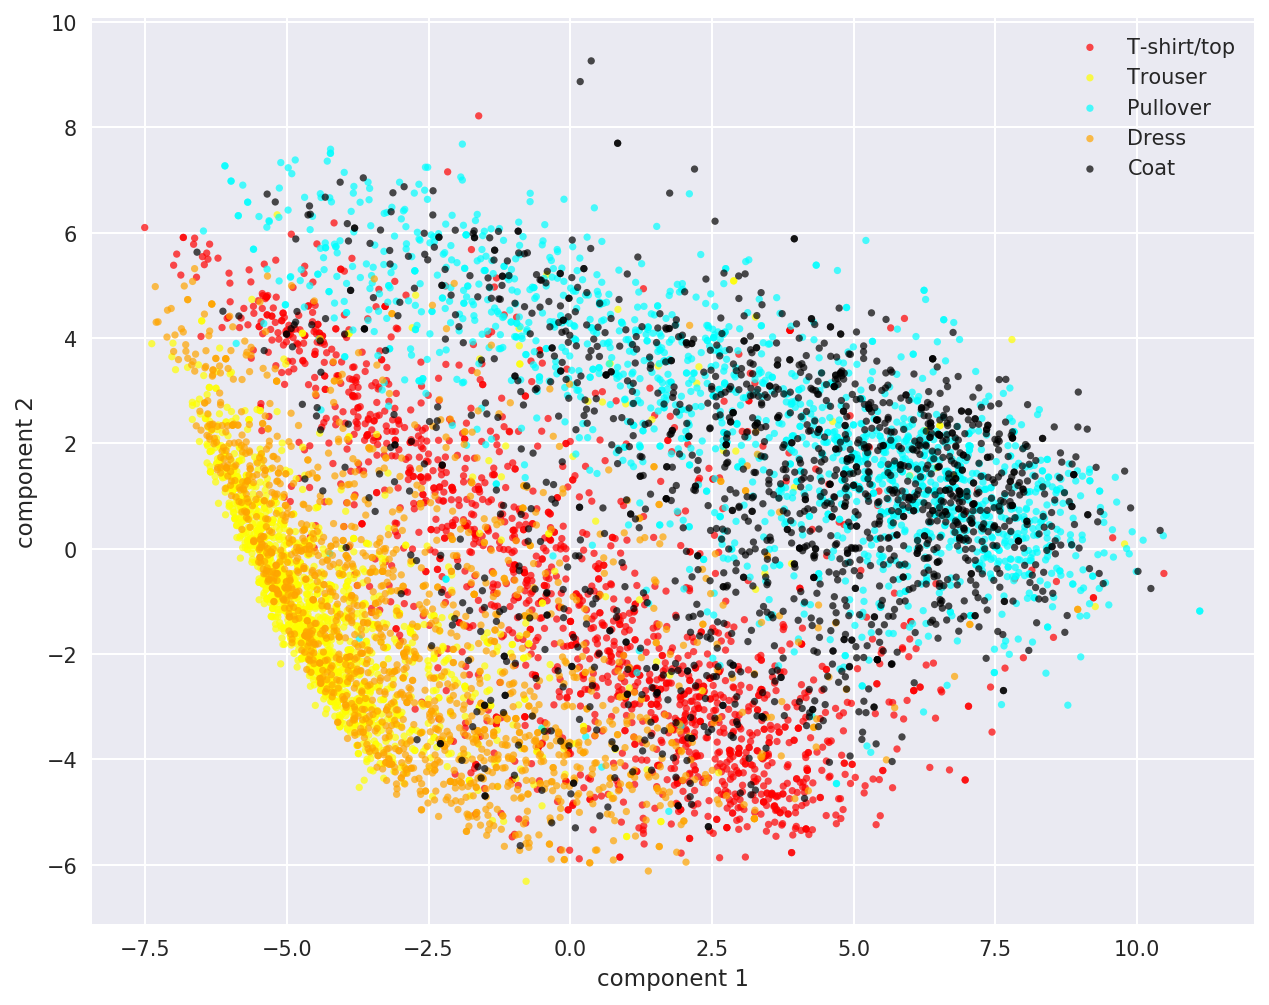

In [7]:
## project from 784 to 2 dimensions
fig = plt.figure(figsize=(10, 8), dpi=150, facecolor="white")
colors = np.array(["red", "yellow", "cyan", "orange", "black", "grey", "green", "royalblue"])
ax = fig.add_subplot(111)
pca = PCA(2)
projected = pca.fit_transform(X_train)
rand_inds = np.random.randint(0, projected.shape[0], 8000)
for class_num in subset:
    _rand_ind = rand_inds[y_train[rand_inds] == class_num]
    ax.scatter(projected[_rand_ind, 0], projected[_rand_ind, 1], c=colors[class_num], 
               edgecolor="none", marker=".", alpha=0.7, label=class_names[class_num])
ax.set_xlabel("component 1")
ax.set_ylabel("component 2")
ax.legend();

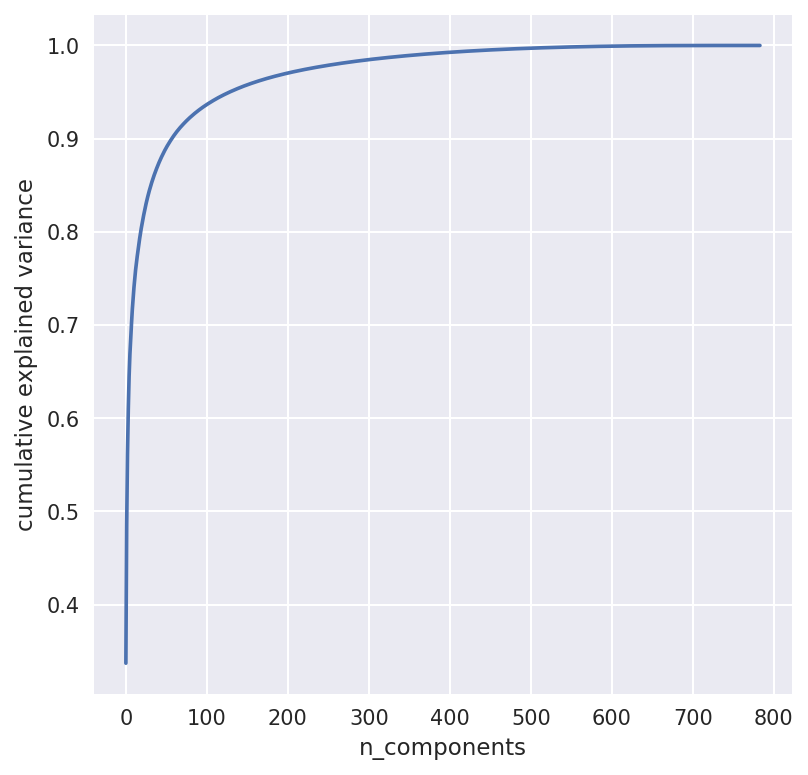

In [8]:
pca = PCA().fit(X_train)
fig = plt.figure(figsize=(6,6), dpi=150, facecolor="white")
ax = fig.add_subplot(111)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel("n_components")
ax.set_ylabel("cumulative explained variance");

## PCA in a Pipeline

In [9]:
pipe = Pipeline([("pca", PCA()), 
                 ("svm", SVC(class_weight="balanced"))])

param_grid = {
    "pca__n_components":[5,10,25],
    "svm__C":[0.001,0.1,1.0,10.0],
    "svm__gamma":[0.1,0.01]
}

In [10]:
## grid search
saved_model = "pca-svm.joblib"
if not os.path.exists(saved_model):
    time_start = time.time()
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, iid=False, n_jobs=-1)
    grid.fit(X_train, y_train)
    joblib.dump(grid, saved_model)
    print("train time", time.strftime("%H:%M:%S", time.gmtime(time.time() - time_start)))
else:
    print("loading {} from file".format(saved_model))
    grid = joblib.load(saved_model)
    
# print best params
print(grid.best_params_)

loading pca-svm.joblib from file
{'pca__n_components': 25, 'svm__C': 1.0, 'svm__gamma': 0.1}


In [11]:
from sklearn.metrics import classification_report
y_pred = grid.predict(X_test)
print("-->".join(pipe.named_steps.keys()))
print(classification_report(y_test, y_pred, target_names=np.array(class_names)[subset]))

pca-->svm
              precision    recall  f1-score   support

 T-shirt/top       0.93      0.93      0.93      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.83      0.85      0.84      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.85      0.85      0.85      1000

   micro avg       0.90      0.90      0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [12]:
from sklearn.manifold import TSNE

# project from 784 to 2 dimensions
saved_model = "fashion-tsne.joblib"
if not os.path.exists(saved_model):
    time_start = time.time()
    pca = PCA(50)
    pca_projected = pca.fit_transform(X_train)
    tsne = TSNE(n_components=2, perplexity=30.0, init="pca")
    tsne_projected = tsne.fit_transform(pca_projected)
    joblib.dump(tsne_projected, saved_model)
    print("train time", time.strftime("%H:%M:%S", time.gmtime(time.time() - time_start)))
else:
    print("loading {} from file".format(saved_model))
    tsne_projected = joblib.load(saved_model)
    
def make_tsne_plot():
    fig = plt.figure(figsize=(8,8), facecolor="white")
    colors = np.array(["red", "yellow", "cyan", "orange", "black", "grey", "green", "royalblue"])
    ax = fig.add_subplot(111)
    rand_inds = np.random.randint(0, projected.shape[0], 8000)
    
    for class_num in subset:
        _rand_ind = rand_inds[y_train[rand_inds] == class_num]
        ax.scatter(tsne_projected[_rand_ind, 0],
                   tsne_projected[_rand_ind, 1], c=colors[class_num], 
                   edgecolor="none", marker=".", alpha=0.7, label=class_names[class_num])
    
    ax.set_xlabel("component 1")
    ax.set_ylabel("component 2")
    ax.legend();

loading fashion-tsne.joblib from file


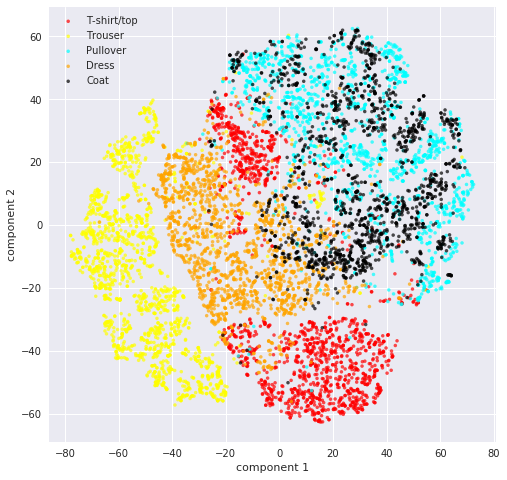

In [13]:
make_tsne_plot()